In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('/data7/brandon/research/DA_MVR/sil_consistent_at_inference')
import sys

import torch
from PIL import Image
import numpy as np
import trimesh
import matplotlib.pyplot as plt
import cv2
from scipy import ndimage
from skimage.transform import resize
from skimage import img_as_bool
from tqdm import tqdm

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes
from pytorch3d.io import load_obj

# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    SoftPhongShader
)

from plot_image_grid import image_grid

In [3]:
# based on https://github.com/facebookresearch/pytorch3d/issues/51
def load_untextured_mesh(mesh_path, device):
    mesh = load_objs_as_meshes([mesh_path], device=device, load_textures = False)
    verts, faces_idx, _ = load_obj(mesh_path)
    faces = faces_idx.verts_idx
    verts_rgb = torch.ones_like(verts)[None] # (1, V, 3)
    textures = Textures(verts_rgb=verts_rgb.to(device))
    mesh_no_texture = Meshes(
        verts=[verts.to(device)],
        faces=[faces.to(device)],
        textures=textures
        )
    return mesh_no_texture

In [4]:
def render_mesh(mesh, R, T, device):
    cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)
    raster_settings = RasterizationSettings(
        image_size=512, 
        blur_radius=0.0, 
        faces_per_pixel=1, 
    )
    lights = PointLights(device=device, location=[[0.0, 5.0, -10.0]])
    renderer = MeshRenderer(
        rasterizer=MeshRasterizer(
            cameras=cameras, 
            raster_settings=raster_settings
        ),
        shader=SoftPhongShader(
            device=device, 
            cameras=cameras,
            lights=lights
        )
    )

    rendered_images = renderer(mesh, cameras=cameras)
    return rendered_images

In [5]:
def crop_binary_mask(mask):
    # Get the height and width of bbox
    objs = ndimage.find_objects(mask)
    # upper left, lower right
    img_bbox = [objs[0][0].start, objs[0][1].start, objs[0][0].stop, objs[0][1].stop]
    # crop
    cropped_mask = mask[img_bbox[0]:img_bbox[2],img_bbox[1]:img_bbox[3] ]
    return cropped_mask


# given an 4 channel image (w1 x h1 x rgba), assumed to be an object on a white background and a mask (w2 x h2 x 1)
# will crop the image and mask, resize them, and then compute the IoU
# (mask is the gt mask, img is rendered reconstruction)
def get_normalized_iou(img, mask, show_intermediate = False):
    img_mask = img[:,:,3] > 0
    img_mask_cropped = crop_binary_mask(img_mask)
    mask_cropped = crop_binary_mask(mask)
    # resize the image to the mask's dimensions
    img_mask_resized = img_as_bool(resize(img_mask_cropped, mask_cropped.shape))
    
    overlap = img_mask_resized*mask_cropped # Logical AND
    union = img_mask_resized + mask_cropped # Logical OR
    IOU = overlap.sum()/float(union.sum())
    
    if show_intermediate:
        #plt.imshow(img_mask_cropped)
        #plt.show()
        plt.imshow(mask_cropped)
        plt.show()
        plt.imshow(img_mask_resized)
        plt.show()
    return IOU

In [6]:
# given a mesh and a mask, finds position of the camera by brute force
def brute_force_estimate_pose(mesh, mask, num_azims, num_elevs, device, batch_size = 8):
    # setting up
    torch.cuda.set_device(device)
    num_renders = num_elevs * num_azims
    azims = torch.linspace(0, 360, num_azims).repeat(num_elevs)
    elevs = torch.repeat_interleave(torch.linspace(0, 180, num_elevs), num_azims) # TODO: also add underneath elevs
    
    # rendering from many different viewpoints on sphere
    meshes = mesh.extend(batch_size)
    renders = []
    for batch_i in tqdm(range(int(np.ceil(num_renders/batch_size)))):
        pose_idx_start = batch_i * batch_size
        pose_idx_end = min((batch_i+1) * batch_size, num_renders)
        batch_azims = azims[pose_idx_start:pose_idx_end]
        batch_elevs = elevs[pose_idx_start:pose_idx_end]
        
        R, T = look_at_view_transform(2.7, batch_elevs, batch_azims) 
        if batch_azims.shape[0] != batch_size:
            meshes = mesh.extend(batch_azims.shape[0])
        batch_renders = render_mesh(meshes, R, T, device)
        renders.append(batch_renders)
    renders = torch.cat(renders)
    
    # computing iou of mask and renders
    iou_calcs = []
    for i in range(renders.shape[0]):
        iou = get_normalized_iou(renders[i].cpu().numpy(), mask, False)
        iou_calcs.append(iou)
        #print("azim: {}, elev: {}, iou: {}".format(azims[i], elevs[i], iou))
    
    # selecting render pose with highest iou 
    iou_argsort = np.argsort(iou_calcs)[::-1]
    iou_highest_idx = iou_argsort[0]
    print("highest iou: {}, azim: {}, elev: {}".format(iou_calcs[iou_highest_idx], azims[iou_highest_idx], elevs[iou_highest_idx]))
    
    # visualizing results
    #get_normalized_iou(renders[iou_highest_idx].cpu().numpy(), mask, True)
    #plt.imshow(renders[iou_highest_idx, ..., :3].cpu().numpy())
    #plt.show()
    
    return azims[iou_highest_idx], elevs[iou_highest_idx]

In [7]:
#cc5dea482768651ed0e93cdb469eb63
img_path = "notebooks/img.jpg"
image = np.asarray(Image.open(img_path).convert('RGB'))

mask_path = "notebooks/img_mask.png"
mask = np.asarray(Image.open(mask_path))
mask = (mask[:,:,3]> 0)

device = torch.device("cuda:7")
mesh_path = "notebooks/mesh.obj"
mesh = load_untextured_mesh(mesh_path, device)

pred_azim, pred_elev = brute_force_estimate_pose(mesh, mask, 20, 20, device)

/data7/drone_machinelearning/anaconda3/envs/standard/lib/python3.7/site-packages/pytorch3d/io/obj_io.py:70: UserWarning: Faces have invalid indices
  warnings.warn("Faces have invalid indices")
100%|██████████| 50/50 [01:01<00:00,  1.23s/it]


highest iou: 0.632659361012502, azim: 56.842105865478516, elev: 37.894737243652344


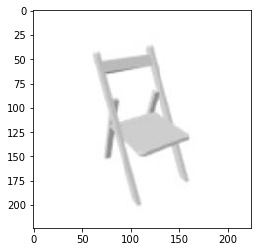

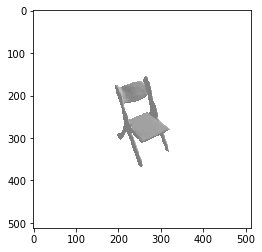

In [8]:
# TODO: make sure elev, azim order is consistent
R, T = look_at_view_transform(2.7, pred_elev, pred_azim) 
mesh_rendered_at_pred_pose = render_mesh(mesh, R, T, device)

plt.imshow(image)
plt.show()
plt.imshow(mesh_rendered_at_pred_pose[0, ..., :3].cpu().numpy())